# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-02-14 14:11:46--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-02-14 14:11:47--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd2c5a942616d812b9bea13d5c8.dl.dropboxusercontent.com/cd/0/inline/BI6w5lie82Rq53DbLP9WHCkm7CgdPk0shcCHplGHzmyZX_SCdk-M33FX57UKTabj6TYlRShHlySGKTJo3iAWhD3s2LbWldgSZ8UyjiI8zTD11HUKHh9aUSbVGWdLPcrOQqo/file# [following]
--2021-02-14 14:11:48--  https://ucd2c5a942616d812b9bea13d5c8.dl.dropboxusercontent.com/cd/0/inline/BI6w5lie82Rq53DbLP9WHCkm7CgdPk0shcCHplGHzmyZX_SCdk-M33FX57UKTabj6TYlRShHlySGKTJo3iAWhD3s2LbWld

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [6]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [7]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [8]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [9]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [10]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 21.18800000002375
100 101.0


In [11]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [12]:
data.sample(10)

,italian,english_inp,english_out
196177,ero geloso di mio fratello,<start> i was jealous of my brother,i was jealous of my brother <end>
313721,a chi tocca preparare la cena stasera,<start> whose turn is it to make dinner tonight,whose turn is it to make dinner tonight <end>
186328,tom si fermò per dare unocchiata,<start> tom stopped to look around,tom stopped to look around <end>
116479,urlo quasi ogni giorno,<start> i cry almost every day,i cry almost every day <end>
174184,sembri un po nervosa,<start> you seem a little nervous,you seem a little nervous <end>
315785,tom ha intenzione di essere alla riunione di oggi,<start> is tom planning to be at today is meeting,is tom planning to be at today is meeting <end>
313391,la figlia maggiore di tom non è ancora sposata,<start> tom is older daughter is still unmarried,tom is older daughter is still unmarried <end>
24039,siete inutili,<start> you are useless,you are useless <end>
4832,ti ho trovata,<start> i found you,i found you <end>
131203,quanto costa,<start> how much does this cost,how much does this cost <end>


In [13]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [14]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [15]:
train.head()

,italian,english_inp,english_out
181991,a molta gente piace viaggiare,<start> many people like to travel <end>,many people like to travel <end> <end>
282689,questo non mi ricorda niente,<start> this does not remind me of anything,this does not remind me of anything <end>
237080,io non avevo idea che tom fosse un medico,<start> i had no idea tom was a doctor,i had no idea tom was a doctor <end>
342808,dato che ha il mal di gola e la febbre probabi...,<start> since you have a sore throat and a fev...,since you have a sore throat and a fever you s...
216786,tom mi ha detto che odia ballare,<start> tom told me you hate dancing,tom told me you hate dancing <end>


In [16]:
validation.head()

,italian,english_inp,english_out
201564,tom ha bisogno di soldi per luniversità,<start> tom needs money for college,tom needs money for college <end>
297224,tom e mary lavorano molto bene assieme,<start> tom and mary work very well together,tom and mary work very well together <end>
161165,dai il mio amore ai tuoi bambini,<start> give my love to your kids,give my love to your kids <end>
239093,sto risparmiando per comprare una nuova auto,<start> i am saving up to buy a new car,i am saving up to buy a new car <end>
333276,quegli uomini stavano parlando in francese o i...,<start> were those men speaking in french or i...,were those men speaking in french or in englis...


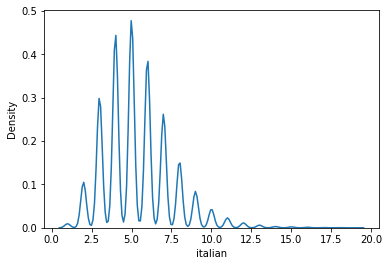

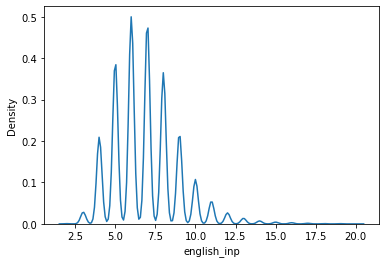

In [17]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [18]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [19]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12827
26197


In [20]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10116)

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.vocab_size = inp_vocab_size
      self.embedding_dim = embedding_size
      self.input_length = input_length
      self.lstm_size= lstm_size

    def build(self, input_shape):
      self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
      self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer


    def call(self,input_sequence,states):
      input_embedd                           = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        #'''
          #This function takes a sequence input and the initial states of the encoder.
          #Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          #returns -- encoder_output, last time step's hidden and cell state

       # '''
    def get_states(self):
      return self.lstm_state_h,self.lstm_state_c
      

    
    def initialize_states(self,batch_size):
      self.lstm_state_h= tf.zeros(shape=[batch_size,self.lstm_size])
      self.lstm_state_c=tf.zeros(shape=[batch_size,self.lstm_size])
      return [self.lstm_state_h,self.lstm_state_c]


      #'''
     # Given a batch size it will return intial hidden state and intial cell state.
      #If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      #'''
      


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.vocab_size = inp_vocab_size
      self.embedding_dim = embedding_size
      self.input_length = input_length
      self.lstm_size= lstm_size

      self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder", trainable=True)
      self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
      input_embedd                           = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c



<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [21]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [22]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
      super().__init__() # https://stackoverflow.com/a/27134600/4084039
      self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length, lstm_size=256)
      self.decoder = Decoder(inp_vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_inputs_length, lstm_size=256)
      self.dense    = Dense(output_vocab_size, activation='softmax')
    
    def call(self, data):
      input,output = data[0], data[1]
      initial_state=self.encoder.initialize_states(1024)
      encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
      states = [encoder_h, encoder_c]
      decoder_output,_,_                       = self.decoder(output,states)
      output                               = self.dense(decoder_output)
      return output
        
        

In [ ]:
model  = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam(lr = 0.01)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024  
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
268/268 [==============================] - 93s 331ms/step - loss: 1.8493 - val_loss: 1.2325
Epoch 2/10
268/268 [==============================] - 86s 321ms/step - loss: 1.0914 - val_loss: 0.7130
Epoch 3/10
268/268 [==============================] - 86s 322ms/step - loss: 0.6022 - val_loss: 0.4472
Epoch 4/10
268/268 [==============================] - 87s 323ms/step - loss: 0.3563 - val_loss: 0.3380
Epoch 5/10
268/268 [==============================] - 86s 322ms/step - loss: 0.2408 - val_loss: 0.2839
Epoch 6/10
268/268 [==============================] - 86s 322ms/step - loss: 0.1824 - val_loss: 0.2580
Epoch 7/10
268/268 [==============================] - 87s 323ms/step - loss: 0.1463 - val_loss: 0.2427
Epoch 8/10
268/268 [==============================] - 86s 320ms/step - loss: 0.1201 - val_loss: 0.2354
Epoch 9/10
268/268 [==============================] - 87s 323ms/step - loss: 0.1051 - val_loss: 0.2311
Epoch 10/10
268/268 [==============================] - 87s 323ms/step - l

In [ ]:
dic_ita = dict(zip(tknizer_ita.word_index.keys(),tknizer_ita.word_index.values()))
dic_eng = dict(zip(tknizer_eng.word_index.keys(),tknizer_eng.word_index.values()))
def predict(input_sentence):

  eng_word = [i for i in tknizer_eng.word_index.keys()]

  sentences = input_sentence['italian'].values

  sentence_translate = []
  
  for i in range(len(sentences)):
    encoder_seq = [[dic_ita[j] for j in sentences[i].split()  if j in dic_ita]]
    encoder_seq = pad_sequences(encoder_seq, maxlen=20, dtype='int32', padding='post')
    
    encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=20, lstm_size=256)
    initial_state=encoder.initialize_states(1)
    enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq,initial_state)
    states_values = [enc_state_h, enc_state_c]

    words_index = []
    cur_vec = np.ones((1, 1))
    for i in range(len(encoder_seq[0])):
      cur_emb = model.layers[1].embedding(cur_vec)
      infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=states_values)
      infe_output=model.layers[2](infe_output)
      states_values = [state_h, state_c]
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      words_index.append(cur_vec[0][0])


    #words = [eng_word[i+1] for i in words_index]
    words = [eng_word[i+1] for i in words_index]
    complete_sentence = ' '.join(words)
    sentence_translate.append(complete_sentence)

  return sentence_translate

In [ ]:
import nltk.translate.bleu_score as bleu
import statistics 
random_sentence = validation.sample(n = 1000, random_state = 24)
#random_sentence = validation.head(1000)
sen = random_sentence['english_out'].values
sentence_translate = predict(random_sentence)

score_list = []
for i in range(1000):
  score_list.append(bleu.sentence_bleu(sen[i][1:], sentence_translate[i][:-1]))
score_list = np.array(score_list)
avg_bleu = statistics.mean(score_list)
print(f'AVG BLEU score: {avg_bleu}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


AVG BLEU score: 0.5319236169481667


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [23]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.vocab_size = inp_vocab_size
      self.embedding_dim = embedding_size
      self.input_length = input_length
      self.lstm_size= lstm_size

      self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
      self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer


    def call(self,input_sequence,states,training=True):
      input_embedd                           = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        #'''
          #This function takes a sequence input and the initial states of the encoder.
          #Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          #returns -- encoder_output, last time step's hidden and cell state
       # '''

      

    
    def initialize_states(self,batch_size):
      self.lstm_state_h= tf.zeros(shape=[batch_size,self.lstm_size])
      self.lstm_state_c=tf.zeros(shape=[batch_size,self.lstm_size])
      return [self.lstm_state_h,self.lstm_state_c]


<font color='cyan'>**Grader function - 1**</font>

In [24]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [25]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function


    if self.scoring_function=='dot':
      self.att_units=att_units

    if scoring_function == 'general':
      self.att_units=att_units
      self.weight = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)


    elif scoring_function == 'concat':
      self.att_units=att_units
      self.weight1 = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
      self.weight2 = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
      self.v = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

  
  
  def call(self,decoder_hidden_state,encoder_output):
    
    if self.scoring_function == 'dot':
    
      decoder_hidden_state = tf.keras.layers.Reshape((self.att_units, 1))(decoder_hidden_state)
      score = tf.keras.layers.dot([encoder_output,decoder_hidden_state], axes=[2, 1])
      
      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = attention_weights * encoder_output
      context_vector = tf.reduce_sum(context_vector, axis=1)
      
      return context_vector, attention_weights

    elif self.scoring_function == 'general':
      weight = self.weight
      weight = weight(shape=(encoder_output.shape[0],self.att_units, self.att_units))
      weight = tf.keras.layers.Reshape((self.att_units, self.att_units))(weight)
      decoder_hidden_state = tf.keras.layers.Reshape((self.att_units, 1))(decoder_hidden_state)

      score = tf.keras.layers.dot([encoder_output,weight], axes=[2, 1])
      score = tf.keras.layers.dot([score,decoder_hidden_state], axes=[2, 1])

      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = attention_weights * encoder_output
      context_vector = tf.reduce_sum(context_vector, axis=1)
      
      return context_vector, attention_weights

    elif self.scoring_function == 'concat':
      weight1 = self.weight1
      weight1 = weight1(shape=(encoder_output.shape[0],self.att_units, 10))
      weight1 = tf.keras.layers.Reshape((self.att_units, 10))(weight1)

      weight2 = self.weight2
      weight2 = weight2(shape=(encoder_output.shape[0],self.att_units, 10))
      weight2 = tf.keras.layers.Reshape((self.att_units, 10))(weight2)

      v = self.v
      v = v(shape=(encoder_output.shape[0],1, 10))
      v = tf.keras.layers.Reshape((10, 1))(v)

      decoder_hidden_state = tf.keras.layers.Reshape((1,self.att_units))(decoder_hidden_state)

      dot1 = tf.keras.layers.dot([decoder_hidden_state,weight1], axes=[2, 1])
      dot2 = tf.keras.layers.dot([encoder_output,weight2], axes=[2, 1])


      score = tf.nn.tanh(dot1 + dot2)
    

      score = tf.keras.layers.dot([score,v], axes=[2, 1])

      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = attention_weights * encoder_output
      context_vector = tf.reduce_sum(context_vector, axis=1)

      return context_vector, attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [26]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [27]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()
    self.vocab_size = tar_vocab_size
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.lstm_size= dec_units
    self.scoring_function = score_fun
    self.att_units=att_units

    self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
    self.lstm = LSTM(self.att_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    self.attention   = Attention(scoring_function = self.scoring_function , att_units = self.att_units)

    #self.dense   = Dense(self.vocab_size, activation='softmax')
    self.dense   = Dense(self.vocab_size)

      # Initialize decoder embedding layer, LSTM and any other objects needed


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    states = [state_h,state_c]
    input_embedd                                   = self.embedding(input_to_decoder)

    context_vector, attention_weights              = self.attention(state_h,encoder_output)

    #tf.concat([t1, t2], 0)
    merged     = tf.concat([context_vector, input_embedd[:,0,:]], axis = 1)
    #merged     = np.concatenate((context_vector, input_embedd[:,0,:]), axis = 1)
    dimension = self.att_units + self.embedding_dim
    merged = tf.keras.layers.Reshape((1,dimension ))(merged)

    output,decoder_hidden_state,lstm_state_c = self.lstm(merged,initial_state=states)

    output                               = self.dense(output)


    return output[:,0,:],decoder_hidden_state,lstm_state_c , attention_weights, context_vector


<font color='cyan'>**Grader function - 3**</font>

In [28]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


<font color='blue'>**Decoder**</font>

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.scoring_function = score_fun
      self.att_units=att_units

      self.one_step_decoder   = One_Step_Decoder(self.vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.scoring_function ,self.att_units)
      #Intialize necessary variables and create an object from the class onestepdecoder

        #tf.shape(x)[0]
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
      #all_output = tf.TensorArray(tf.float32, size =input_to_decoder.shape[1] )
      #all_output = tf.TensorArray(tf.float32, size =tf.shape(input_to_decoder)[1] )
      lis = []

      #for timestep in range(input_to_decoder.shape[1]):
      #for timestep in range(tf.shape(input_to_decoder)[1] ):
      for timestep in range(20):
        output,state_h,state_c,attention_weights,context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)

        # Store the output in tensorarray
        #all_output = all_output.write(timestep,output)
        output = tf.expand_dims(output, axis=1)
        lis.append(output)

      #all_output = tf.transpose(all_output.stack(), [1,0,2])  
      #all_output = tf.TensorArray(all_output)
      all_output = tf.concat(lis, 1)

      return all_output

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [30]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,scoring_function,encoder_inputs_length,decoder_inputs_length,output_vocab_size):
    super().__init__()
    self.scoring_function = scoring_function
    self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length, lstm_size=256)
    self.decoder=Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length, dec_units = 256 ,score_fun = self.scoring_function ,att_units = 256)


  
  def call(self,data):
    input,output = data[0], data[1]
    initial_state=self.encoder.initialize_states(1024)
    encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
    Output                               = self.decoder(output,encoder_output, encoder_h, encoder_c)

    return Output

<font color='blue'>**Custom loss function**</font>

In [31]:
# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
import  datetime 


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, 
                                                      write_graph=True,write_grads=True)


callback_list = [tensorboard_callback]

In [36]:
model  = encoder_decoder(scoring_function = 'dot',encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
rms = tf.keras.optimizers.RMSprop(lr=0.01)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_delta=1e-4, mode='min')
model.compile(optimizer=rms,loss=loss_function)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = [reduce_lr_loss,callback_list])
model.summary()

Epoch 1/10
268/268 [==============================] - 123s 336ms/step - loss: 1.5666 - val_loss: 0.6345
Epoch 2/10
268/268 [==============================] - 80s 300ms/step - loss: 0.5174 - val_loss: 0.3839
Epoch 3/10
268/268 [==============================] - 81s 301ms/step - loss: 0.3033 - val_loss: 0.3142
Epoch 4/10
268/268 [==============================] - 81s 300ms/step - loss: 0.2238 - val_loss: 0.2802
Epoch 5/10
268/268 [==============================] - 81s 302ms/step - loss: 0.1792 - val_loss: 0.2619
Epoch 6/10
268/268 [==============================] - 81s 303ms/step - loss: 0.1497 - val_loss: 0.2508
Epoch 7/10
268/268 [==============================] - 80s 300ms/step - loss: 0.1295 - val_loss: 0.2436
Epoch 8/10
268/268 [==============================] - 82s 304ms/step - loss: 0.1169 - val_loss: 0.2402
Epoch 9/10
268/268 [==============================] - 82s 305ms/step - loss: 0.1022 - val_loss: 0.2375
Epoch 10/10
268/268 [==============================] - 82s 307ms/step - 

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [33]:
# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention
dic_ita = dict(zip(tknizer_ita.word_index.keys(),tknizer_ita.word_index.values()))
dic_eng = dict(zip(tknizer_eng.word_index.keys(),tknizer_eng.word_index.values()))
eng_word = [i for i in tknizer_eng.word_index.keys()]
def evaluate(sentence):
  #attention_plot = np.zeros((encoder_seq[0], encoder_seq[0]))

  inputs = [[dic_ita[j] for j in sentence.split()  if j in dic_ita]]
  encoder_seq = pad_sequences(inputs, maxlen=20, dtype='int32', padding='post')
    
  encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=20, lstm_size=256)
  initial_state=encoder.initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq,initial_state)


  attention_plot = np.zeros((len(encoder_seq[0]), len(encoder_seq[0])))
  words_index = []
  cur_vec = np.ones((1, 1))
  for i in range(len(encoder_seq[0])):
    infe_output,state_h,state_c,attention_weights,context_vector = model.layers[1].one_step_decoder(cur_vec,enc_output,enc_state_h,enc_state_c)


    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    #li.append(attention_weights)
    attention_plot[i] = attention_weights.numpy()

    #predicted_id = tf.argmax(infe_output[0]).numpy()

    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))

    if eng_word[cur_vec[0][0] + 1 ] == '<end>':
      break

    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
    words_index.append(cur_vec[0][0])

  words = [eng_word[i+1] for i in words_index]  
  result = ' '.join(words)



  return result, sentence, attention_plot

In [34]:
import matplotlib.ticker as ticker
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

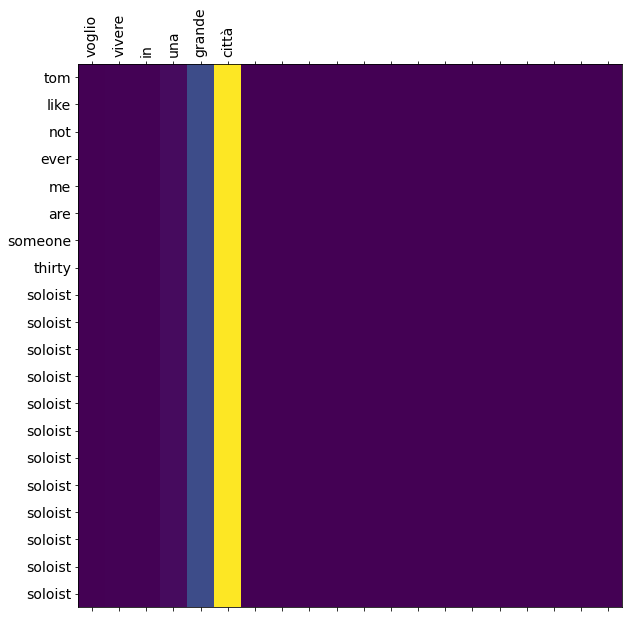

In [45]:
result, sentence, attention_plot = evaluate('voglio vivere in una grande città')
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<font color='blue'>**Predict the sentence translation**</font>

In [35]:
dic_ita = dict(zip(tknizer_ita.word_index.keys(),tknizer_ita.word_index.values()))
dic_eng = dict(zip(tknizer_eng.word_index.keys(),tknizer_eng.word_index.values()))
def predict(input_sentence):

  eng_word = [i for i in tknizer_eng.word_index.keys()]

  sentences = input_sentence['italian'].values

  sentence_translate = []
  
  for i in range(len(sentences)):
    encoder_seq = [[dic_ita[j] for j in sentences[i].split()  if j in dic_ita]]
    encoder_seq = pad_sequences(encoder_seq, maxlen=20, dtype='int32', padding='post')
    
    encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=20, lstm_size=256)
    initial_state=encoder.initialize_states(1)
    enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq,initial_state)
    #states_values = [enc_state_h, enc_state_c]

    words_index = []
    cur_vec = np.ones((1, 1))
    for i in range(len(encoder_seq[0])):
   
      infe_output,state_h,state_c,attention_weights,context_vector = model.layers[1].one_step_decoder(cur_vec,enc_output,enc_state_h,enc_state_c)
      #infe_output=model.layers[2](infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      words_index.append(cur_vec[0][0])

    words = [eng_word[i+1] for i in words_index]
    complete_sentence = ' '.join(words)
    sentence_translate.append(complete_sentence)

  return sentence_translate




<font color='blue'>**Predict the sentence translation**</font>

In [44]:
import nltk.translate.bleu_score as bleu
import statistics 
random_sentence = validation.sample(n = 1000, random_state = 24)
#random_sentence = validation.head(1000)
sen = random_sentence['english_out'].values
sentence_translate = predict(random_sentence)

score_list = []
for i in range(1000):
  score_list.append(bleu.sentence_bleu(sen[i][1:], sentence_translate[i][:-1]))
score_list = np.array(score_list)
avg_bleu = statistics.mean(score_list)
print(f'AVG BLEU score: {avg_bleu}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


AVG BLEU score: 0.5334978478291761


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [36]:
model  = encoder_decoder(scoring_function = 'general',encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
#optimizer = tf.keras.optimizers.Adam()
optimizer=tf.keras.optimizers.Adam(lr=0.01)
rms = tf.keras.optimizers.RMSprop(lr=0.01)
#model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_delta=1e-4, mode='min')
model.compile(optimizer=rms,loss=loss_function)
#model.compile(optimizer=rms,loss=loss_object)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
#model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = [reduce_lr_loss,callback_list])
model.summary()

Epoch 1/10
268/268 [==============================] - 409s 1s/step - loss: 1.5656 - val_loss: 0.6207
Epoch 2/10
268/268 [==============================] - 365s 1s/step - loss: 0.5177 - val_loss: 0.3848
Epoch 3/10
268/268 [==============================] - 366s 1s/step - loss: 0.3077 - val_loss: 0.3088
Epoch 4/10
268/268 [==============================] - 366s 1s/step - loss: 0.2244 - val_loss: 0.2755
Epoch 5/10
268/268 [==============================] - 364s 1s/step - loss: 0.1780 - val_loss: 0.2573
Epoch 6/10
268/268 [==============================] - 364s 1s/step - loss: 0.1505 - val_loss: 0.2486
Epoch 7/10
268/268 [==============================] - 365s 1s/step - loss: 0.1291 - val_loss: 0.2390
Epoch 8/10
268/268 [==============================] - 365s 1s/step - loss: 0.1144 - val_loss: 0.2361
Epoch 9/10
268/268 [==============================] - 365s 1s/step - loss: 0.1027 - val_loss: 0.2344
Epoch 10/10
268/268 [==============================] - 365s 1s/step - loss: 0.0931 - val_lo

<font color='blue'>**Predict the sentence translation**</font>

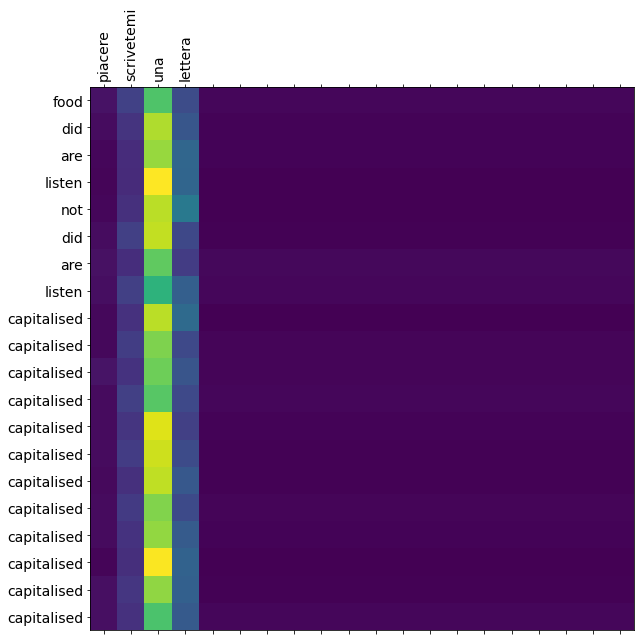

In [ ]:
result, sentence, attention_plot = evaluate('piacere scrivetemi una lettera')

plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [40]:
import nltk.translate.bleu_score as bleu
import statistics 
random_sentence = validation.sample(n = 1000, random_state = 24)
#random_sentence = validation.head(1000)
sen = random_sentence['english_out'].values
sentence_translate = predict(random_sentence)

score_list = []
for i in range(1000):
  score_list.append(bleu.sentence_bleu(sen[i][1:], sentence_translate[i][:-1]))
score_list = np.array(score_list)
avg_bleu = statistics.mean(score_list)
print(f'AVG BLEU score: {avg_bleu}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


AVG BLEU score: 0.5556624022880127


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
model  = encoder_decoder(scoring_function = 'concat',encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
#optimizer = tf.keras.optimizers.Adam()
optimizer=tf.keras.optimizers.Adam(lr=0.01)
rms = tf.keras.optimizers.RMSprop(lr=0.01)
#model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_delta=1e-4, mode='min')
model.compile(optimizer=rms,loss=loss_function)
#model.compile(optimizer=rms,loss=loss_object)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
#model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps)
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,callbacks = [reduce_lr_loss,callback_list])
model.summary()

Epoch 1/10
268/268 [==============================] - 143s 436ms/step - loss: 1.5179 - val_loss: 0.6286
Epoch 2/10
268/268 [==============================] - 111s 415ms/step - loss: 0.4973 - val_loss: 0.4113
Epoch 3/10
268/268 [==============================] - 112s 419ms/step - loss: 0.3044 - val_loss: 0.3513
Epoch 4/10
268/268 [==============================] - 114s 424ms/step - loss: 0.2233 - val_loss: 0.3222
Epoch 5/10
268/268 [==============================] - 115s 427ms/step - loss: 0.1763 - val_loss: 0.3100
Epoch 6/10
268/268 [==============================] - 114s 426ms/step - loss: 0.1461 - val_loss: 0.3064
Epoch 7/10
268/268 [==============================] - 115s 427ms/step - loss: 0.1273 - val_loss: 0.3013
Epoch 8/10
268/268 [==============================] - 114s 427ms/step - loss: 0.1142 - val_loss: 0.3028

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 9/10
268/268 [==============================] - 114s 427ms/step - loss: 0.0782 - 

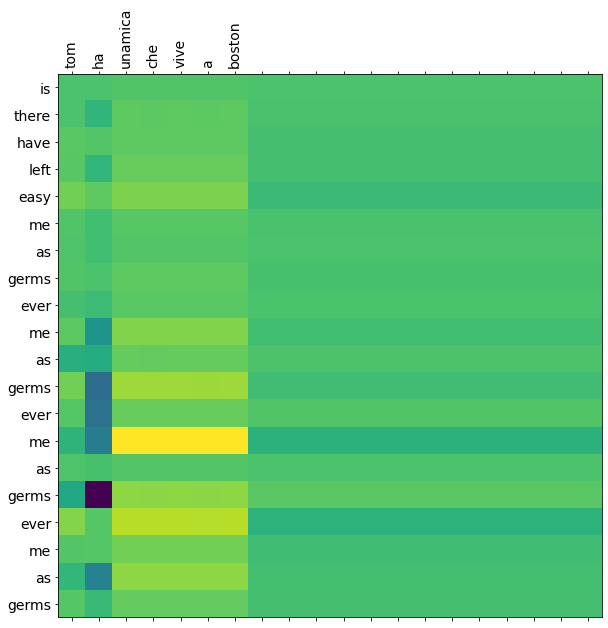

In [ ]:
result, sentence, attention_plot = evaluate('tom ha unamica che vive a boston')
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
import nltk.translate.bleu_score as bleu
import statistics 
random_sentence = validation.sample(n = 1000, random_state = 24)
#random_sentence = validation.head(1000)
sen = random_sentence['english_out'].values
sentence_translate = predict(random_sentence)

score_list = []
for i in range(1000):
  score_list.append(bleu.sentence_bleu(sen[i][1:], sentence_translate[i][:-1]))
score_list = np.array(score_list)
avg_bleu = statistics.mean(score_list)
print(f'AVG BLEU score: {avg_bleu}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


AVG BLEU score: 0.5550113821123829


# Observation

1. Out of three scoring funtion, validation loss is decreased in general funtion with highest BLEU score. 
2.Attention plot seems improve in general and concat funtion as compare to dot funtion.
3.Since the complexity of models is high in all 3 cases, model is getting overfitting. 